In [1]:
path_price = '../../raw_data/pro_btc_60min_price_df_v2.csv'
columns_to_keep_price = ['date', 'open', 'high', 'low', 'adj_close', 'volume']
columns_to_drop=['open', 'high', 'low', 'adj_close', 'volume']

## 1. Stuff

In [2]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Flatten, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.regularizers import l1, l2, l1_l2

from sklearn.cluster import KMeans
import pprint

from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.initializers import glorot_normal
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.metrics import Precision, Recall

from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import F1Score
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.utils.multiclass import unique_labels
from keras.initializers import glorot_normal


In [3]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))

    # --- LOSS ---

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])

    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')

    ax[0].legend(['Train', 'Val'], loc='best')

    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- ACCURACY

    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])

    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')

    ax[1].legend(['Train', 'Val'], loc='best')

    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)


In [4]:
def plot_confusion_matrix(y_true, y_pred, title=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    squeezed_array = np.squeeze(y_true)

    if not title:
        title = 'Confusion Matrix'

    # Compute confusion matrix
    cm = confusion_matrix(squeezed_array, y_pred)

    # Get class labels
    classes = unique_labels(squeezed_array, y_pred)

    # Create a heatmap using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues",
                xticklabels=classes, yticklabels=classes)

    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [221]:
def plot_roc_curve1(y_true_cls, y_pred_prob):

    fpr, tpr, _ = roc_curve(y_true_cls, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()


## 2. Import Data

In [6]:
def import_price_data(path_price, columns_to_keep_price):
    price_data = pd.read_csv(path_price)
    price_df = price_data.copy()
    price_df = price_df[columns_to_keep_price]
    price_df.set_index('date', inplace=True)

    return price_df


In [7]:
price_df = import_price_data(path_price, columns_to_keep_price)

## 3. Labeling

### a. Add Labels

In [8]:
def labeling_df(price_df):
    """
    Label a DataFrame by creating a new column 'label', set all values to 0 in that column,
    set the values to 1 if open price is lower than adjusted close.

    Parameters:
    - formated_df (pd.DataFrame): Input DataFrame.

    Returns:
    - pd.DataFrame: labeled DataFrame.
    """
    # Step 1: Create a new column 'Label' and initialize with 0 (down)
    price_df['label'] = 0

    # Step 2: Label +1 (up) where 'Open' is lower than 'Adj Close'
    price_df.loc[price_df['open'] < price_df['adj_close'], 'label'] = 1

    # Step 4: Rename df
    labeled_df = price_df

    return labeled_df


In [9]:
labeled_df = labeling_df(price_df)

### b. Analyse Labels

In [10]:
num_bins = labeled_df['label'].nunique()
label_counts = labeled_df['label'].value_counts()

print(f'Number of Bins: {num_bins}')
print(f'Number of labels per Bins: {label_counts}')


Number of Bins: 2
Number of labels per Bins: label
0    31644
1    31194
Name: count, dtype: int64


## 4. Feature Engeneering

### a. MA5 & MA20

In [11]:
def moving_averages(df, column_name='adj_close', window_sizes=[5, 20]):
    """
    Add Moving Averages (MA) columns to the DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which moving averages are calculated.
    - window_sizes (list): List of window sizes for moving averages. Default is [5, 20].

    Returns:
    - pd.DataFrame: DataFrame with added MA columns.
    """
    for window_size in window_sizes:
        ma_column_name = f'MA_{window_size}'
        df[ma_column_name] = df[column_name].rolling(window=window_size).mean()

    return df


### b. BBup & BBdown

In [12]:
def bollinger_bands(df, column_name='adj_close', window_size=20, num_std_dev=2):
    """
    Calculate Bollinger Bands for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which Bollinger Bands are calculated.
    - window_size (int): Window size for the moving average. Default is 20.
    - num_std_dev (int): Number of standard deviations for the upper and lower bands. Default is 2.

    Returns:
    - pd.DataFrame: DataFrame with added columns for Bollinger Bands (BB up, BB down).
    """
    # Calculate the rolling mean (middle band)
    df['middle_band'] = df[column_name].rolling(window=window_size).mean()

    # Calculate the rolling standard deviation
    df['std_dev'] = df[column_name].rolling(window=window_size).std()

    # Calculate Bollinger Bands
    df['bb_up'] = df['middle_band'] + num_std_dev * df['std_dev']
    df['bb_down'] = df['middle_band'] - num_std_dev * df['std_dev']

    # Drop intermediate columns
    df.drop(['middle_band', 'std_dev'], axis=1, inplace=True)

    return df


### c. RDP1

In [13]:
def rdp(df, column_name='adj_close'):
    """
    Calculate Relative Difference in the Percentage of the price (RDP(1)) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which RDP(1) is calculated.

    Returns:
    - pd.DataFrame: DataFrame with an added column for RDP(1).
    """
    # Calculate RDP(1)
    df['rdp_1'] = df[column_name].pct_change() * 100

    return df


### d. BIAS6, BIAS12, BIAS24

In [14]:
def bias(df, column_name='adj_close', ma_windows=[6, 12, 24]):
    """
    Calculate Bias Ratios (BIAS) for specified moving average windows for a column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which BIAS is calculated.
    - ma_windows (list): List of moving average window sizes. Default is [6, 12, 24].

    Returns:
    - pd.DataFrame: DataFrame with added columns for BIAS(6), BIAS(12), and BIAS(24).
    """
    for window_size in ma_windows:
        ma_column_name = f'MA_{window_size}'
        bias_column_name = f'BIAS_{window_size}'

        # Calculate the moving average
        df[ma_column_name] = df[column_name].rolling(window=window_size).mean()

        # Calculate BIAS
        df[bias_column_name] = ((df[column_name] - df[ma_column_name]) / df[ma_column_name]) * 100

        # Drop intermediate columns
        df.drop(ma_column_name, axis=1, inplace=True)

    return df


### e. RSI

In [15]:
def rsi(df, column_name='adj_close', window=14):
    """
    Calculate the Relative Strength Index (RSI) for a specified column in a DataFrame.

    Parameters:
    - df: (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which RSI is calculated. Default is 'Close'.
    - window (int): Window size for RSI calculation. Default is 14.

    Returns:
    - pd.DataFrame: DataFrame with an added column for RSI.
    """
    # Calculate daily price changes
    df['price_change'] = df[column_name].diff()

    # Calculate the average gain and average loss over the specified window
    df['gain'] = df['price_change'].apply(lambda x: x if x > 0 else 0).rolling(window=window, min_periods=1).mean()
    df['loss'] = -df['price_change'].apply(lambda x: x if x < 0 else 0).rolling(window=window, min_periods=1).mean()

    # Calculate relative strength (RS)
    df['rs'] = df['gain'] / df['loss']

    # Calculate RSI
    df['rsi'] = 100 - (100 / (1 + df['rs']))

    # Drop intermediate columns
    df.drop(['price_change', 'gain', 'loss', 'rs'], axis=1, inplace=True)

    return df


### f. EMA12 & EMA26

In [16]:
def ema(df, column_name='adj_close', ema_short=12, ema_long=26):
    """
    Calculate Exponential Moving Averages (EMA) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which EMA is calculated. Default is 'Close'.
    - ema_short (int): Short-term EMA window size. Default is 12.
    - ema_long (int): Long-term EMA window size. Default is 26.

    Returns:
    - pd.DataFrame: DataFrame with added columns for EMA(12) and EMA(26).
    """
    # Calculate EMA(12)
    df['ema_12'] = df[column_name].ewm(span=ema_short, adjust=False).mean()

    # Calculate EMA(26)
    df['ema_26'] = df[column_name].ewm(span=ema_long, adjust=False).mean()

    return df


### g. MACD

In [17]:
def macd(df, column_name='adj_close', ema_short=12, ema_long=26, signal_period=9):
    """
    Calculate Moving Average Convergence Divergence (MACD) and its signal line for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which MACD is calculated. Default is 'Close'.
    - ema_short (int): Short-term EMA window size. Default is 12.
    - ema_long (int): Long-term EMA window size. Default is 26.
    - signal_period (int): Signal line EMA window size. Default is 9.

    Returns:
    - pd.DataFrame: DataFrame with added columns for MACD, Signal Line, and MACD Histogram.
    """
    # Calculate short-term EMA
    df['ema_short'] = df[column_name].ewm(span=ema_short, adjust=False).mean()

    # Calculate long-term EMA
    df['ema_long'] = df[column_name].ewm(span=ema_long, adjust=False).mean()

    # Calculate MACD Line
    df['dif'] = df['ema_short'] - df['ema_long']

    # Calculate Signal Line
    df['signal_line'] = df['dif'].ewm(span=signal_period, adjust=False).mean()

    # Calculate MACD Histogram
    df['osc'] = df['dif'] - df['signal_line']

    # Drop intermediate columns
    df.drop(['ema_short', 'ema_long'], axis=1, inplace=True)

    return df


### h. PSY(12) & PSY(24)

In [18]:
def psy(df, column_name='adj_close', psy_short=12, psy_long=24):
    """
    Calculate Psychological Line (PSY) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which PSY is calculated. Default is 'Close'.
    - psy_short (int): Short-term PSY window size. Default is 12.
    - psy_long (int): Long-term PSY window size. Default is 24.

    Returns:
    - pd.DataFrame: DataFrame with added columns for PSY(12) and PSY(24).
    """
    # Calculate the percentage of days where the closing price is higher than the previous day's closing price
    df['price_up'] = df[column_name].diff() > 0

    # Calculate PSY(12)
    df['psy_12'] = df['price_up'].rolling(window=psy_short).mean() * 100

    # Calculate PSY(24)
    df['psy_24'] = df['price_up'].rolling(window=psy_long).mean() * 100

    # Drop intermediate columns
    df.drop(['price_up'], axis=1, inplace=True)

    return df


### i. WMS%R

In [19]:
def williams_percent_r(df, high_column='high', low_column='low', adj_close_column='adj_close', window=14):
    """
    Calculate Williams %R for a specified high, low, and close columns in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - high_column (str): Name of the column containing high prices. Default is 'High'.
    - low_column (str): Name of the column containing low prices. Default is 'Low'.
    - adj_close_column (str): Name of the column containing close prices. Default is 'Close'.
    - window (int): Window size for Williams %R calculation. Default is 14.

    Returns:
    - pd.DataFrame: DataFrame with an added column for Williams %R.
    """
    # Calculate highest high and lowest low over the specified window
    df['hh'] = df[high_column].rolling(window=window).max()
    df['ll'] = df[low_column].rolling(window=window).min()

    # Calculate Williams %R
    df['williams_%r'] = (df['hh'] - df[adj_close_column]) / (df['hh'] - df['ll']) * -100

    # Drop intermediate columns
    df.drop(['hh', 'll'], axis=1, inplace=True)

    return df


### j. Stochastic%K & Stochastic%D

In [20]:
def stochastic_oscillator(df, high_column='high', low_column='low', adj_close_column='adj_close', k_window=14, d_window=3):
    """
    Calculate Stochastic Oscillator (%K and %D) for specified high, low, and close columns in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - high_column (str): Name of the column containing high prices. Default is 'High'.
    - low_column (str): Name of the column containing low prices. Default is 'Low'.
    - close_column (str): Name of the column containing close prices. Default is 'Close'.
    - k_window (int): Window size for %K calculation. Default is 14.
    - d_window (int): Window size for %D calculation. Default is 3.

    Returns:
    - pd.DataFrame: DataFrame with added columns for Stochastic %K and %D.
    """
    # Calculate lowest low and highest high over the specified window
    df['ll'] = df[low_column].rolling(window=k_window).min()
    df['hh'] = df[high_column].rolling(window=k_window).max()

    # Calculate Stochastic %K
    df['stochastic_%k'] = ((df[adj_close_column] - df['ll']) / (df['hh'] - df['ll'])) * 100

    # Calculate Stochastic %D (3-day simple moving average of %K)
    df['stochastic_%d'] = df['stochastic_%k'].rolling(window=d_window).mean()

    # Drop intermediate columns
    df.drop(['ll', 'hh'], axis=1, inplace=True)

    return df


### k. PROC

In [21]:
def proc(df, column_name='adj_close', window=1):
    """
    Calculate Percentage of Price Change (PROC) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which PROC is calculated. Default is 'Close'.
    - window (int): Window size for PROC calculation. Default is 1.

    Returns:
    - pd.DataFrame: DataFrame with an added column for PROC.
    """
    # Calculate the percentage change in price using rolling window
    df['proc'] = df[column_name].pct_change().rolling(window=window).mean() * 100

    return df


### l. MO1

In [22]:
def momentum(df, column_name='adj_close', window=1):
    """
    Calculate Momentum (MO) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which Momentum is calculated. Default is 'Close'.
    - window (int): Window size for Momentum calculation. Default is 1.

    Returns:
    - pd.DataFrame: DataFrame with an added column for Momentum.
    """
    # Calculate the difference in price over the specified window
    df['momentum'] = df[column_name].diff(window)

    return df


### m. LAG1

In [23]:
def first_order_lag(df, column_name='adj_close', lag=1):
    """
    Calculate First-Order Lag (LAG(1)) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column for which the lag is calculated. Default is 'Close'.
    - lag (int): Number of periods to lag. Default is 1.

    Returns:
    - pd.DataFrame: DataFrame with an added column for the First-Order Lag.
    """
    # Calculate the First-Order Lag using the shift() method
    df[f'LAG_{lag}'] = df[column_name].shift(lag)

    return df


### n. VOL

In [24]:
def trading_volume(df, volume_column='volume'):
    """
    Calculate Trading Volume (VOL) for a specified column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - volume_column (str): Name of the column containing trading volume. Default is 'Volume'.

    Returns:
    - pd.DataFrame: DataFrame with an added column for Trading Volume.
    """
    df['vol'] = df[volume_column]

    return df


## 5. Preprocessing

### a. Feature Selection

In [25]:
def feature_selection(labeled_df):

    moving_averages(labeled_df)
    bollinger_bands(labeled_df)
    rdp(labeled_df)
    bias(labeled_df)
    rsi(labeled_df)
    ema(labeled_df)
    macd(labeled_df)
    psy(labeled_df)
    williams_percent_r(labeled_df)
    stochastic_oscillator(labeled_df)
    proc(labeled_df)
    momentum(labeled_df)
    first_order_lag(labeled_df)
    trading_volume(labeled_df)

    return labeled_df


In [26]:
labeled_features_df = feature_selection(labeled_df)

### b. Clean

In [27]:
def cleaned_df(labeled_features_df, columns_to_drop=['open', 'high', 'low', 'adj_close', 'volume']):
    """
    Drop specified columns from a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - columns_to_drop (list): List of column names to drop. Default is ['Open', 'High', 'Low', 'Adj_Close', 'Volume'].

    Returns:
    - pd.DataFrame: DataFrame with specified columns dropped.
    """
    # Drop specified columns
    cleaned_df = labeled_features_df.drop(columns=columns_to_drop, errors='Ignore')

    # Drop rows with NaN values
    cleaned_df = cleaned_df.dropna()

    return cleaned_df


In [28]:
cleaned_df = cleaned_df(labeled_features_df, columns_to_drop)

### c. Standadize

In [29]:
def scale_dataframe(cleaned_df):
    """
    Scale a DataFrame using Standard scaling.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.

    Returns:
    - pd.DataFrame: Scaled DataFrame.
    """
    # Scale the selected columns
    scaler = StandardScaler()

    index_column = cleaned_df.index

    label_column = cleaned_df['label']
    int_df = cleaned_df.drop(columns=['label'])

    columns_to_scale = int_df.columns

    scaled_df = pd.DataFrame(scaler.fit_transform(int_df), columns=columns_to_scale)
    scaled_df.index = index_column
    scaled_df['label'] = label_column

    return scaled_df


In [30]:
scaled_df = scale_dataframe(cleaned_df)


### d. Train Test Split

In [31]:
def train_test_split(scaled_df):
    """
    Split a time series dataset into training and testing sets.

    Parameters:
    - df: the input time series dataset.
    - test_size (float): the proportion of the dataset to include in the test split.

    Returns:
    - df_train, df_test: Pandas arrays, representing features and target values for each set.
    """

    # Extract index number of splitting points
    len_df = len(scaled_df)
    index_1 = round(len_df*(1-(0.2)))
    index_2 = index_1 +1

    # Extract values at previously calculated splitting points
    date_1 = scaled_df.index[index_1]
    date_2 = scaled_df.index[index_2]

    # Construct train_df, val_df and test_df
    df_train = scaled_df[:date_1]
    df_test = scaled_df[date_2:]

    return df_train, df_test


In [32]:
df_train, df_test = train_test_split(scaled_df)


### e. Split X & y

In [33]:
def split_X_y(df, window_size=10):
    """
    Reshape a DataFrames into two 3D NumPy arrays

    Parameters:
    - df: DataFrame with a list of time series data
    - window_size: the number of time steps to consider for each observation

    Returns:
    - X: (num_observations, window_size, num_features)
    - y: (num_observations, num_features_to_predict)
    """
    df_np = df.to_numpy()
    X = []
    y = []

    df_X = df.drop('label', axis=1)
    df_y = df['label']

    for i in range(len(df_np)-(window_size)):
        row = df_X[i:i+window_size]
        X.append(row)
        label = df_y[i+(window_size)]
        y.append(label)

    # Shift the labels to get the label of the following sequence
    y_df_shifted = np.roll(df_y, 1)

    # Drop the first element from X_train_shifted and y_train_shifted
    X_df_shifted = df_X[1:]
    y_df_shifted = y_df_shifted[1:]

    X_df_shifted = np.array(X)
    y = np.array(y)
    y_df_shifted = np.expand_dims(y, axis=-1)

    return X_df_shifted, y_df_shifted


In [34]:
X_train, y_train = split_X_y(df_train)
X_test, y_test = split_X_y(df_test)

/var/folders/l4/q_79lrcx3ps_z7hltvr9nl4c0000gn/T/ipykernel_16699/342703497.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = df_y[i+(window_size)]
/var/folders/l4/q_79lrcx3ps_z7hltvr9nl4c0000gn/T/ipykernel_16699/342703497.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = df_y[i+(window_size)]


### f. One Hot Encode

In [35]:
def one_hot_encode(y_train, y_test):

    label_encoder = LabelEncoder()
    encoded_y_train = label_encoder.fit_transform(y_train)
    y_train_cat = to_categorical(encoded_y_train)

    encoded_y_test = label_encoder.transform(y_test)
    y_test_cat = to_categorical(encoded_y_test)

    return y_train_cat, y_test_cat


In [36]:
y_train_cat, y_test_cat = one_hot_encode(y_train, y_test)

/Users/leopolddenassau/.pyenv/versions/3.10.6/envs/Financial_Trend_Forecasting/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/leopolddenassau/.pyenv/versions/3.10.6/envs/Financial_Trend_Forecasting/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


## 11. GRU Model

In [246]:
def gru_model_initialization(X_train, window_size=10):

    #############################
    #  1 - Model architecture   #
    #############################
    normalizer = Normalization()
    normalizer.adapt(X_train)

    model = Sequential()
    model.add(GRU(16, return_sequences=False, input_shape=(window_size, X_train.shape[-1]), kernel_regularizer=l1_l2(l1=0, l2=0.5)))
    model.add(BatchNormalization())
    # model.add(Dropout(0.2))
    # model.add(Dense(8, activation='relu'))
    # model.add(GRU(8, return_sequences=False, activation='tanh'))
    # model.add(Dense(8, activation='relu'))
    # model.add(BatchNormalization())
    # model.add(Dropout(0.3))
    # model.add(GRU(8, return_sequences=False, activation='tanh'))  
    # model.add(BatchNormalization())
    # model.add(Dropout(0.2))
    # model.add(GRU(8, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))

    #############################
    #  2 - Optimization Method  #
    #############################
    model.compile(loss= 'binary_crossentropy',
                  optimizer = Adam(learning_rate=0.0001),
                  metrics = ['accuracy', F1Score()])

    return model


In [247]:
def model_training(model, X_train, y_train):

    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=0.00001)

    history = model.fit(X_train, y_train,
                        validation_split=0.2,
                        batch_size=64,
                        epochs=50,
                        callbacks=[es, reduce_lr],
                        verbose=0)

    return history


### Other

In [248]:
def model_validation(model, X_test, y_test):

    model_acc = model.evaluate(X_test, y_test, verbose=0)

    return model_acc

In [249]:
def model_prediction(model, X_test, threshold=0.50):
    y_pred_probs = model.predict(X_test)

    # Convert predicted probabilities to binary predictions using the threshold
    y_pred_binary = (y_pred_probs >= threshold).astype(int)

    # Convert binary predictions to the class labels
    y_pred = np.argmax(y_pred_binary, axis=1)

    return y_pred_probs, y_pred_binary, y_pred

## 12. Run Model

In [250]:
model = gru_model_initialization(X_train)
history = model_training(model, X_train, y_train_cat)
model_acc = model_validation(model, X_test, y_test_cat)

## 13. Train, Val, Test Evaluation

In [251]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_17 (GRU)                (None, 16)                1968      
                                                                 
 batch_normalization_15 (Ba  (None, 16)                64        
 tchNormalization)                                               
                                                                 
 dense_17 (Dense)            (None, 2)                 34        
                                                                 
Total params: 2066 (8.07 KB)
Trainable params: 2034 (7.95 KB)
Non-trainable params: 32 (128.00 Byte)
_________________________________________________________________


In [252]:
print(f'loss train vs val: {history.history["loss"][-1]:.7f} vs {history.history["val_loss"][-1]:.7f}')
print(f'accuracy train vs val: {history.history["accuracy"][-1]:.7f} vs {history.history["val_accuracy"][-1]:.7f}')
print(f'F1 score train vs val: {history.history["f1_score"][-1]} vs {history.history["val_f1_score"][-1]}')
print(f'Learning Rate train vs val: {history.history["lr"][-1]}')

loss train vs val: 0.6877636 vs 0.6979202
accuracy train vs val: 0.5456197 vs 0.5199602
F1 score train vs val: [0.580212  0.5048143] vs [0.37425384 0.61062664]
Learning Rate train vs val: 9.999999747378752e-06


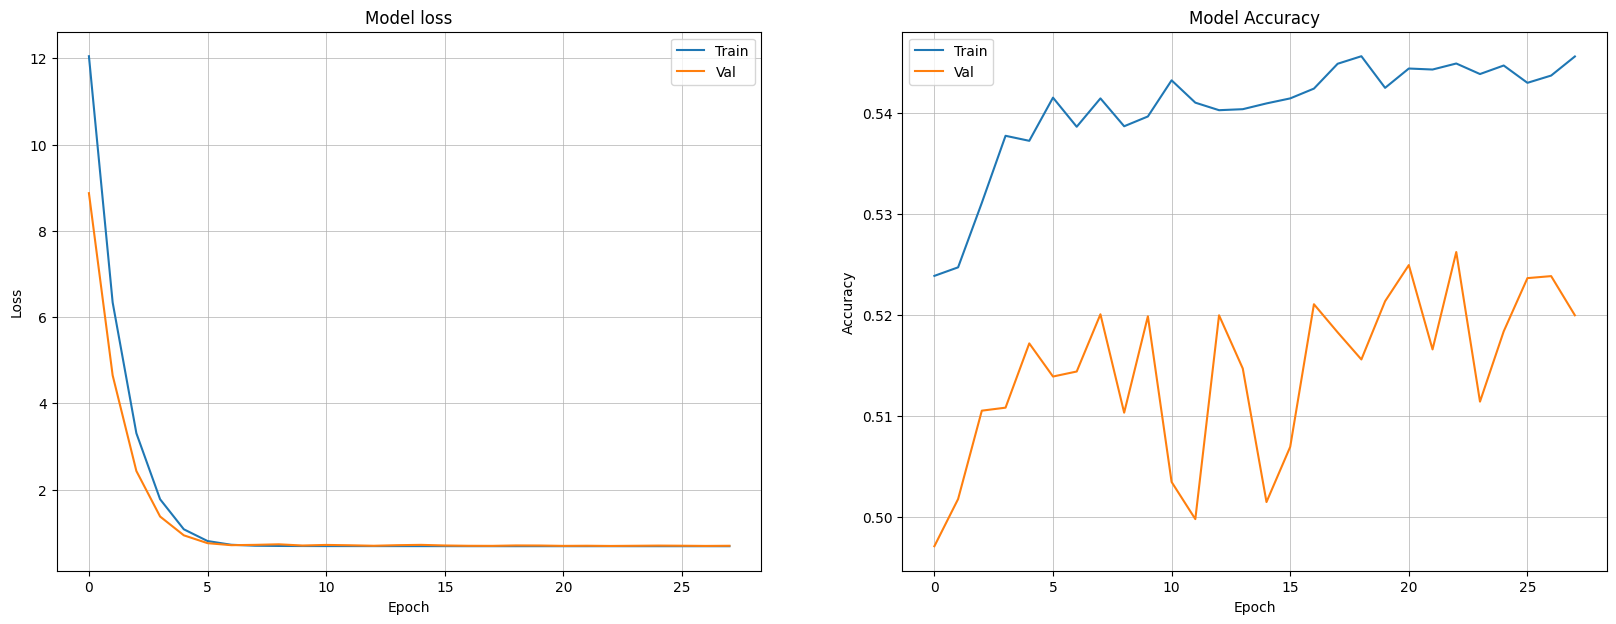

In [253]:
plot_loss_accuracy(history)

In [254]:
print(f'The loss on the test set: {model_acc[0]:.7f}')
print(f'The accuracy on the test set: {model_acc[1]:.7f}')
print(f'The F1 score on the test set: {model_acc[2]}')

The loss on the test set: 0.6918323
The accuracy on the test set: 0.5365426
The F1 score on the test set: [0.47664478 0.58413786]


## 14. Prediction Evaluation

In [255]:
y_pred_probs, y_pred_binary, y_pred = model_prediction(model, X_test)

393/393 [==============================] - 0s 602us/step


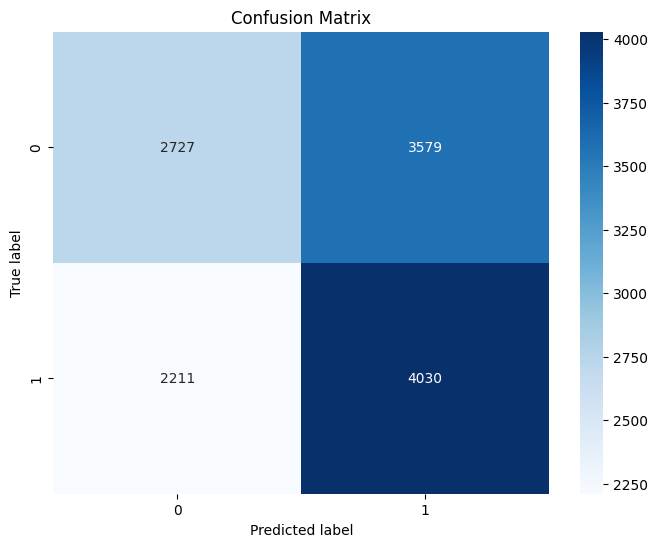

In [256]:
plot_confusion_matrix(y_test, y_pred)

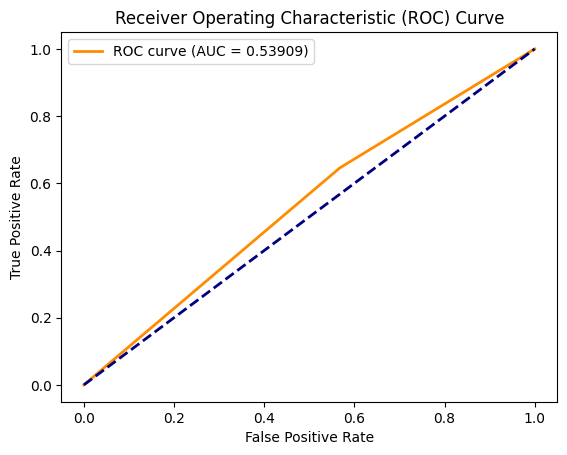

In [257]:
plot_roc_curve1(y_test, y_pred)